Before generating the first figures, run the cells below to import everything we need and set up matplolib.

In [24]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from sklearn.preprocessing import minmax_scale

In [25]:
plt.style.use(r"figures.mplstyle")

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
   new_cmap = colors.LinearSegmentedColormap.from_list(
      'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
      cmap(np.linspace(minval, maxval, n)))
   return new_cmap

colors = plt.cm.Dark2(np.linspace(0,1,8))
# colors = plt.cm.tab20(np.linspace(0,1,20))

# Plot settings
DPI=600
fig_width_pt = 450  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean # height in inches
x_lim = [1994, 2022]

First we want to display how many stocks are eligible when we look at the citerions separately.

In [26]:
# Read dataframes and do some counting

def unusableReturns(ric, year):
    selection = df_returns[ric][(df_returns.index >= f"{year}-01-01") & (df_returns.index <= f"{year}-12-31")]
    return bool(selection.isna().values.any())

df_market_cap = pd.read_pickle("UsableData/MarketCap.pkl")
df_employees = pd.read_pickle("UsableData/Employees.pkl")
df_book_value = pd.read_pickle("UsableData/BookValue.pkl")
df_variance = pd.read_pickle("UsableData/Variance.pkl")
df_sales = pd.read_pickle("UsableData/Sales.pkl")
df_returns = pd.read_pickle("UsableData/Returns.pkl").T
df_eligible = pd.read_pickle("UsableData/EligibleStocks.pkl")
df_raw = pd.read_csv("RawData/FirmData.csv")
df_raw["Year"] = pd.to_datetime(df_raw["Date"], dayfirst=True).dt.year
df_raw = df_raw.pivot(index="RIC", columns="Year", values="Total Equity")

x = df_eligible.columns.to_list()
y_MC = np.zeros(len(x))
y_EMP = np.zeros(len(x))
y_BV = np.zeros(len(x))
y_VAR = np.zeros(len(x))
y_SAL = np.zeros(len(x))
y_RT = np.zeros(len(x))
y_EL = np.zeros(len(x))
y_Ref = np.full(len(x), len(df_raw.index))

for year in x:
    df = df_eligible[df_eligible[year] == True]
    i = x.index(year)
    y_EL[i] = len(df.index)
for ric in df_market_cap.index:
    for year in x:
        mc = df_market_cap.loc[ric, year]
        emp = df_employees.loc[ric, year]
        bv = df_book_value.loc[ric, year]
        var = df_variance.loc[ric, year]
        sal = df_variance.loc[ric, year]
        i = x.index(year)
        if not math.isnan(mc):
            y_MC[i] +=1
        if not math.isnan(emp):
            y_EMP[i] += 1
        if not math.isnan(bv):
            y_BV[i] += 1
        if not math.isnan(var):
            y_VAR[i] += 1
        if not math.isnan(sal):
            y_SAL[i] += 1
        if not unusableReturns(ric, year):
            y_RT[i] += 1

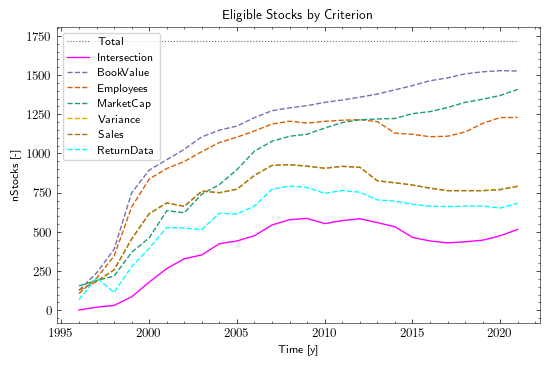

In [27]:
# Plot number of eligible stocks by criterion

fig = plt.figure(figsize = (fig_width, fig_height))

plt.plot(x, y_Ref, label="Total", color= colors[7], linestyle="dotted", linewidth=0.8)
plt.plot(x, y_EL, label="Intersection", color = "magenta")
plt.plot(x, y_BV, label="BookValue", color = colors[2], linestyle="dashed")
plt.plot(x, y_EMP, label="Employees", color = colors[1], linestyle="dashed")
plt.plot(x, y_MC, label="MarketCap", color = colors[0], linestyle="dashed")
plt.plot(x, y_VAR, label="Variance", color = colors[5], linestyle="dashed")
plt.plot(x, y_SAL, label="Sales", color = colors[6], linestyle="dashed")
plt.plot(x, y_RT, label="ReturnData", color = "cyan", linestyle="dashed")


plt.title("Eligible Stocks by Criterion")
plt.xlabel("Time [y]")
plt.ylabel("nStocks [-]")
plt.legend(loc="best")

plt.savefig('Figures/nStocks.png', pad_inches = .1, bbox_inches = 'tight', dpi=DPI)
plt.savefig('Figures/nStocks.pdf', pad_inches = .1, bbox_inches = 'tight')

Compare raw return data to filtered return data to see the effects of the outlier detection

In [28]:
# Read and prepare dataframes
df_returns = pd.read_pickle("UsableData/Returns.pkl")
returns_flat = df_returns.T.to_numpy().flatten()
returns_flat = returns_flat[~np.isnan(returns_flat)]

df_raw = pd.read_csv('RawData/Returns.csv', index_col="RIC")
df_raw.columns = pd.to_datetime(df_raw.columns, dayfirst=True)
raw_flat = df_raw.T.to_numpy().flatten()
raw_flat = raw_flat[~np.isnan(raw_flat)]

E = [raw_flat, returns_flat]

In [29]:
# Implement custom tick locator to display minor ticks in linear and logarithmic part of y-axis
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))

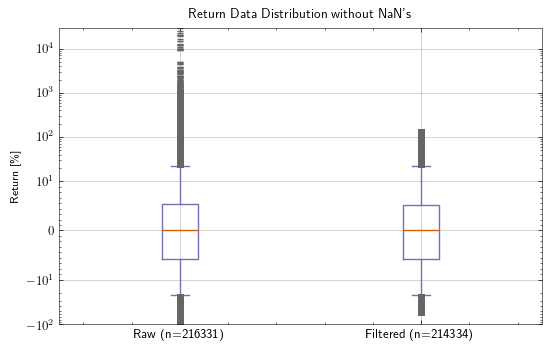

In [30]:
# Plot boxplot

fig = plt.figure(figsize = (fig_width, fig_height))
plt.yscale('symlog', subs=(np.arange(4)+1)*2, linthresh=10, linscale=1.0)
yaxis = plt.gca().yaxis
yaxis.set_minor_locator(MinorSymLogLocator(1))
plt.ylim([-100, 30000])

boxprops = dict(color=colors[2])
flierprops = dict(marker='_', markerfacecolor=colors[7], markersize=5,
                  markeredgecolor=colors[7])
medianprops = dict(color=colors[1])
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
whiskerprops = dict(color=colors[2])

plot = plt.boxplot(E, labels=(f"Raw (n={len(raw_flat)})", f"Filtered (n={len(returns_flat)})"), boxprops=boxprops, flierprops=flierprops, whiskerprops=whiskerprops, capprops=whiskerprops, medianprops=medianprops)
plt.ylabel("Return [\%]")
plt.title("Return Data Distribution without NaN's")
plt.grid()

plt.savefig('Figures/ReturnsComparison.png', pad_inches = .1, bbox_inches = 'tight', dpi=DPI)
plt.savefig('Figures/ReturnsComparison.pdf', pad_inches = .1, bbox_inches = 'tight')


Plot simulation results

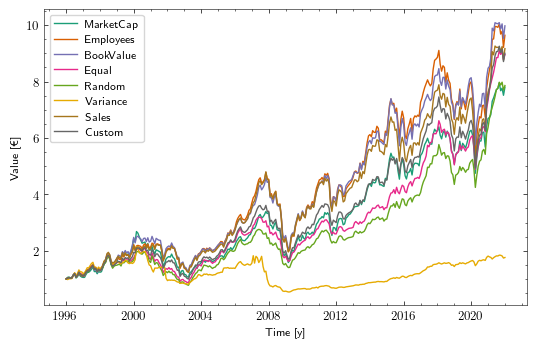

In [45]:
# Plot results
df_results = pd.read_pickle("UsableData/Results.pkl")

fig = plt.figure(figsize = (fig_width, fig_height))

plt.plot(df_results["Market Cap"], label="MarketCap", color=colors[0])
plt.plot(df_results["Employees"], label="Employees", color=colors[1])
plt.plot(df_results["Book Value"], label="BookValue", color=colors[2])
plt.plot(df_results["Equal"], label="Equal", color=colors[3])
plt.plot(df_results["Random"], label="Random", color=colors[4])
plt.plot(df_results["Variance"], label="Variance", color=colors[5])
plt.plot(df_results["Sales"], label="Sales", color=colors[6])
plt.plot(df_results["Custom"], label="Custom", color=colors[7])

# plt.title("Growth of a 1€ Investment")
plt.ylabel("Value [€]")
plt.xlabel("Time [y]")
plt.legend()

plt.savefig('Figures/Results.png', pad_inches = .1, bbox_inches = 'tight', dpi=DPI)
plt.savefig('Figures/Results.pdf', pad_inches = .1, bbox_inches = 'tight')

Compare Strategies based on KPIs from Analysis

In [32]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [33]:
df_analysis = pd.read_pickle("UsableData/Analysis.pkl")
df_analysis["Volatility"] = -df_analysis["Volatility"]
for kpi in df_analysis.columns:
    # df_analysis[kpi] -= np.min(df_analysis[kpi])
    # df_analysis[kpi] = df_analysis[kpi]/np.max(df_analysis[kpi]) * 10
    df_analysis[kpi] = minmax_scale(df_analysis[kpi]) * 5
    # df_analysis[kpi] = stats.rankdata(df_analysis[kpi])
# Sort dataframe so that strategies with high total score and therefore much area are drawn first
df_analysis = df_analysis.T
df_analysis.loc["Total"] = df_analysis.sum()
df_analysis = df_analysis.sort_values(by=["Total"], ascending=False, axis=1)
df_analysis.drop(["Total"], inplace=True)

In [34]:
df_analysis2019 = pd.read_pickle("UsableData/Analysis2019.pkl")
df_analysis2019["Volatility"] = -df_analysis2019["Volatility"]
for kpi in df_analysis2019.columns:
    # df_analysis2019[kpi] -= np.min(df_analysis2019[kpi])
    # df_analysis2019[kpi] = df_analysis2019[kpi]/np.max(df_analysis2019[kpi]) * 10
    df_analysis2019[kpi] = minmax_scale(df_analysis2019[kpi]) * 5
    # df_analysis2019[kpi] = stats.rankdata(df_analysis2019[kpi])
    # Sort dataframe so that strategies with high total score and therefore much area are drawn first
df_analysis2019 = df_analysis2019.T
df_analysis2019.loc["Total"] = df_analysis2019.sum()
df_analysis2019 = df_analysis2019.sort_values(by=["Total"], ascending=False, axis=1)
df_analysis2019.drop(["Total"], inplace=True)

In [35]:
N = len(df_analysis.index)
atr = {"Random": [colors[4], 0], "Equal": [colors[3], 1], "Custom": [colors[7], 2], "Employees": [colors[1], 3], "Market Cap": [colors[0], 4], "Book Value": [colors[2], 5], "Sales": [colors[6], 6], "Variance": [colors[5], 7]}
spoke_labels = ['Total\nReturn', 'Yearly\nReturn', 'Volatility', 'Sharpe\nRatio', 'Max\nDrawdown', 'Positive\nMonth']

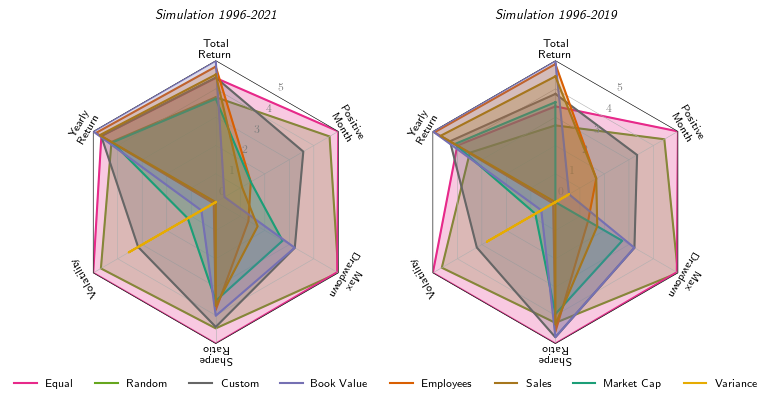

In [36]:
theta = radar_factory(N, frame='polygon')

fig, axes = plt.subplots(figsize=(fig_width, fig_height), subplot_kw=dict(projection='radar'), nrows=1, ncols=2)
# fig.subplots_adjust(left=0, right=1, wspace=0.8)
fig.subplots_adjust(left=0, right=1, top=0.87, bottom=0.13)

ax1 = axes[0]
ax2 = axes[1]

# Up to 2021
yticks_locs = np.linspace(start=0, stop=5, num=6).astype(int)
ax1.set_rgrids(yticks_locs)
ax1.set_ylim([0, 5])
for label in ax1.get_yticklabels():
    x,y = label.get_position()
    lab = ax1.text(2*np.pi*((338-30)/360),y*0.85+0.2, label.get_text(), transform=label.get_transform(),
                ha="left", va=label.get_va(), color="gray")
    lab.set_rotation(0)
ax1.set_yticklabels([])
ax1.set_title("\\textit{Simulation 1996-2021}", ha='center', pad=30)
for strategy in df_analysis.columns:
    line = ax1.plot(theta, df_analysis[strategy].values.tolist(), label=strategy, color=atr[strategy][0], linewidth=1.5, zorder=atr[strategy][1])
    ax1.fill(theta, df_analysis[strategy].values.tolist(), alpha=0.25, color=atr[strategy][0], zorder=atr[strategy][1])
ax1.set_varlabels(spoke_labels)
# Rotate Labels
ax1.xaxis.set_tick_params(pad=1)
thetatick_locs = np.linspace(0, 360, 6, endpoint=False)
for label, angle in zip(ax1.get_xticklabels(), thetatick_locs):
    x,y = label.get_position()
    lab = ax1.text(x,y, label.get_text(), transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va())
    lab.set_rotation(angle)
ax1.set_xticklabels([])
ax1.set_ylim([0, 5])

# Up to 2019
ax2.set_rgrids(yticks_locs)
ax2.set_ylim([0, 5])
for label in ax2.get_yticklabels():
    x,y = label.get_position()
    lab = ax2.text(2*np.pi*((338-30)/360),y*0.85+0.2, label.get_text(), transform=label.get_transform(),
                ha="left", va=label.get_va(), color="gray")
    lab.set_rotation(0)
ax2.set_yticklabels([])
ax2.set_title("\\textit{Simulation 1996-2019}", ha='center', pad=30)

for strategy in df_analysis2019.columns:
    line = ax2.plot(theta, df_analysis2019[strategy].values.tolist(), label=strategy, color=atr[strategy][0], linewidth=1.5, zorder=atr[strategy][1])
    ax2.fill(theta, df_analysis2019[strategy].values.tolist(), alpha=0.25, color=atr[strategy][0], zorder=atr[strategy][1])
ax2.set_varlabels(spoke_labels)
# Rotate Labels
ax2.xaxis.set_tick_params(pad=1)
thetatick_locs = np.linspace(0, 360, 6, endpoint=False)
for label, angle in zip(ax2.get_xticklabels(), thetatick_locs):
    x,y = label.get_position()
    lab = ax2.text(x,y, label.get_text(), transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va())
    lab.set_rotation(angle)
ax2.set_xticklabels([])
ax2.set_ylim([0, 5])

handles, labels = plt.gca().get_legend_handles_labels()
# fig.legend(handles, labels, loc="center", bbox_to_anchor=[0.5, 0.51])
fig.legend(handles, labels, loc="lower center", ncol=len(df_analysis.columns), frameon=False)
# fig.suptitle("\\textbf{Strategy KPI Comparison}")
plt.savefig('Figures/Analysis.png', pad_inches = .1, bbox_inches = "tight", dpi=DPI)
plt.savefig('Figures/Analysis.pdf', pad_inches = .1, bbox_inches = "tight")

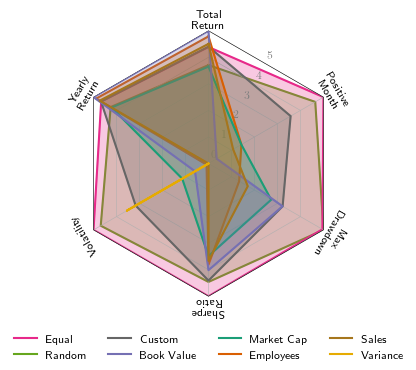

In [37]:
theta = radar_factory(N, frame='polygon')

fig, axes = plt.subplots(figsize=(fig_width, fig_height), subplot_kw=dict(projection='radar'), nrows=1, ncols=1)
fig.subplots_adjust(left=0, right=1, top=0.87, bottom=0.18, wspace=0.8)

ax1 = axes

# Up to 2021
yticks_locs = np.linspace(start=0, stop=5, num=6).astype(int)
ax1.set_rgrids(yticks_locs)
ax1.set_ylim([0, 5])
for label in ax1.get_yticklabels():
    x,y = label.get_position()
    lab = ax1.text(2*np.pi*((338-30)/360),y*0.85+0.2, label.get_text(), transform=label.get_transform(),
                ha="left", va=label.get_va(), color="gray")
    lab.set_rotation(0)
ax1.set_yticklabels([])
for strategy in df_analysis.columns:
    line = ax1.plot(theta, df_analysis[strategy].values.tolist(), label=strategy, color=atr[strategy][0], linewidth=1.5, zorder=atr[strategy][1])
    ax1.fill(theta, df_analysis[strategy].values.tolist(), alpha=0.25, color=atr[strategy][0], zorder=atr[strategy][1])
ax1.set_varlabels(spoke_labels)
# Rotate Labels
ax1.xaxis.set_tick_params(pad=1)
thetatick_locs = np.linspace(0, 360, 6, endpoint=False)
for label, angle in zip(ax1.get_xticklabels(), thetatick_locs):
    x,y = label.get_position()
    lab = ax1.text(x,y, label.get_text(), transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va())
    lab.set_rotation(angle)
ax1.set_xticklabels([])
ax1.set_ylim([0, 5])

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, frameon=False)
# fig.suptitle("\\textbf{Strategy KPI Comparison 1996-2021}")
plt.savefig('Figures/AnalysisSingle.png', pad_inches = .1, bbox_inches = "tight", dpi=DPI)
plt.savefig('Figures/AnalysisSingle.pdf', pad_inches = .1, bbox_inches = "tight")

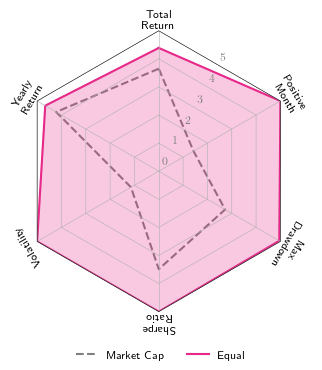

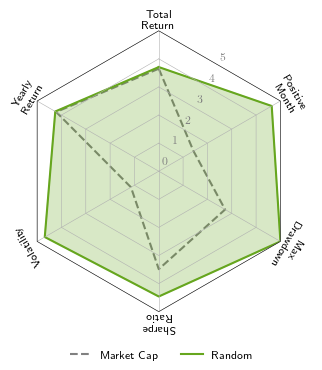

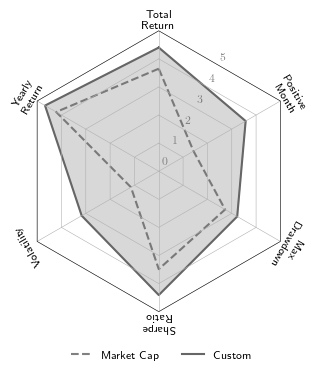

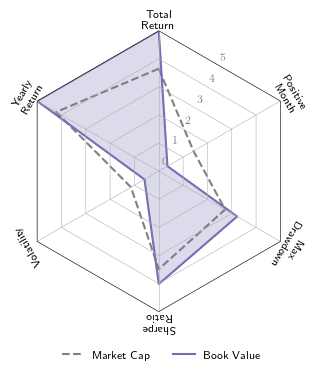

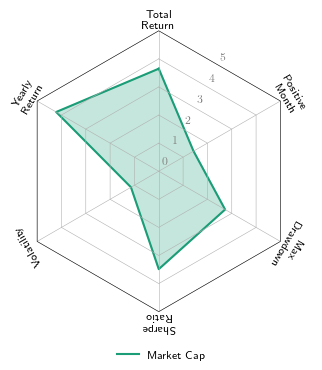

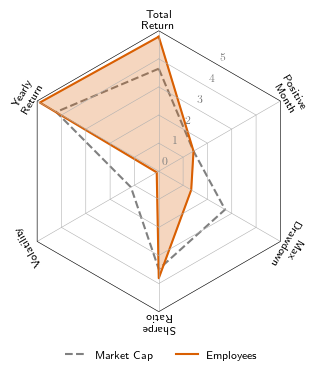

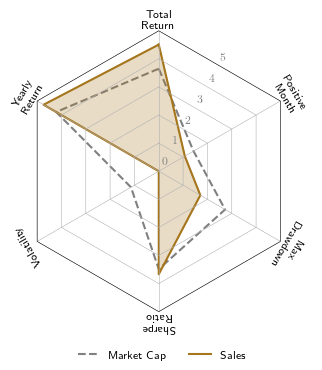

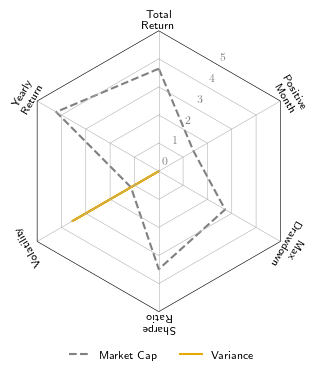

In [51]:
reference = "Market Cap"
for strategy in df_analysis.columns:
    theta = radar_factory(N, frame='polygon')

    fig, axes = plt.subplots(figsize=(fig_width, fig_height), subplot_kw=dict(projection='radar'), nrows=1, ncols=1)
    fig.subplots_adjust(left=0, right=1, top=0.87, bottom=0.14)

    ax1 = axes

    # Up to 2021
    yticks_locs = np.linspace(start=0, stop=5, num=6).astype(int)
    ax1.set_rgrids(yticks_locs)
    ax1.set_ylim([0, 5])
    for label in ax1.get_yticklabels():
        x,y = label.get_position()
        lab = ax1.text(2*np.pi*((338-30)/360),y*0.85+0.2, label.get_text(), transform=label.get_transform(),
                    ha="left", va=label.get_va(), color="gray")
        lab.set_rotation(0)
    ax1.set_yticklabels([])
    if not strategy == reference:
        line2 = ax1.plot(theta, df_analysis[reference].values.tolist(), label=reference, color="grey", linewidth=1.5, zorder=0, linestyle="dashed")
    line = ax1.plot(theta, df_analysis[strategy].values.tolist(), label=strategy, color=atr[strategy][0], linewidth=1.5, zorder=1)
    ax1.fill(theta, df_analysis[strategy].values.tolist(), alpha=0.25, color=atr[strategy][0], zorder=1)
    ax1.set_varlabels(spoke_labels)
    # Rotate Labels
    ax1.xaxis.set_tick_params(pad=1)
    thetatick_locs = np.linspace(0, 360, 6, endpoint=False)
    for label, angle in zip(ax1.get_xticklabels(), thetatick_locs):
        x,y = label.get_position()
        lab = ax1.text(x,y, label.get_text(), transform=label.get_transform(),
                    ha=label.get_ha(), va=label.get_va())
        lab.set_rotation(angle)
    ax1.set_xticklabels([])

    # fig.suptitle("\\textbf{" + strategy + " Strategy KPIs}")
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, frameon=False)
    plt.savefig(f'Figures/Analysis{strategy}.png', pad_inches = .1, bbox_inches = "tight", dpi=DPI)
    plt.savefig(f'Figures/Analysis{strategy}.pdf', pad_inches = .1, bbox_inches = "tight")